# Optimize classification models

To look at the alternatives to accuracy that can be much more useful in machine learning.


#### Alternative metrics for binary classifiers
* **Accuracy** can be misleading with class imbalance.
  Example: if 3% are diabetic, always predicting "no" gives 97% accuracy but fails to detect diabetics.
* Prefer metrics that capture error types: precision, recall, F1, and the confusion matrix.
* Scikit-Learn's classification_report and confusion_matrix summarize these metrics for better insight.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# load the training dataset
diabetes = pd.read_csv('../../generated/data/raw/diabetes.csv')

# Separate features and labels
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
label = 'Diabetic'
X, y = diabetes[features].values, diabetes[label].values


# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

# Train the model
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

predictions = model.predict(X_test)
print('Predicted labels: ', predictions)
print('Actual labels:    ', y_test)


print('Accuracy: ', accuracy_score(y_test, predictions))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

lambda_vals = [1.0, 0.1, 0.01, 0.001]

Cs = [1.0 / l for l in lambda_vals]
coef_norms = []

for l, C in zip(lambda_vals, Cs):
    model = LogisticRegression(C=C, solver='liblinear', max_iter=1000).fit(X_train, y_train)
    coef_norms.append(np.linalg.norm(model.coef_))
    print(f"lambda={l:.3g} -> C={C:.3g}, coef_norm={coef_norms[-1]:.3f}")

plt.figure()
plt.plot(lambda_vals, coef_norms, marker='o')
plt.xscale('log')
plt.gca().invert_xaxis()  # optional: show stronger regularization (larger lambda) on left
plt.xlabel('lambda (regularization rate)')
plt.ylabel('||coef|| (L2 norm)')
plt.title('Coefficient norm vs lambda (log scale)')
plt.grid(True)
plt.show()

* The list [1.0, 0.1, 0.01, 0.001] are values for the regularization rate ($\lambda$) (lambda).
* scikit-learn's `LogisticRegression` uses `C = 1 / lambda`. So:
  - Larger ($\lambda$) -> smaller `C` -> stronger regularization (more shrinkage toward zero).
  - Smaller ($\lambda$) -> larger `C` -> weaker regularization (less shrinkage, larger coefficients).

* That particular list spans three orders of magnitude (decades): it performs a *log-scale* sweep from stronger to weaker regularization (1 → 0.001).
* Typical effect: as lambda decreases (C increases) coefficient norms increase and risk of overfitting grows; as lambda increases coefficients shrink and the model can underfit.
* Practical guidance: search ($\lambda$) on a log scale (e.g. from 1e-4 to 1e2) and pick the best value by cross-validation (e.g. `GridSearchCV` or `LogisticRegressionCV`).

Brief demo (assumes `X_train` and `y_train` exist): the code below maps the lambda values to `C`, fits models, prints C and coefficient norms, and plots coefficient norm vs lambda.


- Regularization penalizes large model weights **to reduce variance and prevent overfitting**; it trades model complexity for smoother, more generalizable decision boundaries.
- In scikit-learn's `LogisticRegression`, the parameter `C` controls regularization and equals `1 / lambda`. A bigger `lambda` means stronger regularization (so `C` is smaller); a smaller lambda means weaker regularization (so C is larger).
- Effects on training: stronger regularization (large `lambda`, small `C`) shrinks coefficients toward zero, may lower training accuracy but often improves test performance; weaker regularization can increase training accuracy but risks overfitting.
- Penalty types: `L2` (ridge) shrinks coefficients smoothly; `L1` (lasso) can set many coefficients exactly to zero (sparse models). Choose based on interpretability and feature selection needs.
- Practical notes: always scale features before regularizing (e.g., `StandardScaler`), search `lambda` or `C` on a log scale (e.g., lambda in [1e-4, 1e2] or C in [1e-2, 1e4]) via cross-validation (`GridSearchCV` or `LogisticRegressionCV`), and pick a solver that supports your penalty (`liblinear`, `saga`, etc.).
- Numerical/convergence: very weak regularization sometimes slows convergence; increase `max_iter` or switch solver if you see convergence warnings.
Brief example: use `LogisticRegressionCV` to tune C (inverse regularization) with scaling and cross-validation.

In [ ]:
# Pipeline scales features, then finds best C on a log scale via cross-validation.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

clf = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(Cs=10**np.linspace(-4, 4, 9), cv=5, penalty='l2', solver='liblinear', max_iter=1000)
)
clf.fit(X_train, y_train)
print("Best C:", clf.named_steps['logisticregressioncv'].C_)

One of the simplest places to start is a classification report. Run the next cell to see a range of alternate ways to assess our model.

In [ ]:
from sklearn. metrics import classification_report

print(classification_report(y_test, predictions))

The classification report includes the following metrics for each class (0 and 1):

* *Precision*: Of the predictions the model made for this class, what proportion were correct?
* *Recall*: Out of all of the instances of this class in the test dataset, how many did the model identify?
* *F1-Score*: An average metric that takes both precision and recall into account.
* *Support*: How many instances of this class are there in the test dataset?

The classification report also includes averages for these metrics, including a weighted average that allows for the imbalance in the number of cases of each class.

Because this is a *binary* classification problem, the ***1*** class is considered *positive* and its precision and recall are particularly interesting - these in effect answer the questions:

    - Of all the patients the model predicted are diabetic, how many are actually diabetic?
    - Of all the patients that are actually diabetic, how many did the model identify?



To You can retrieve these values on their own by using the **precision_score** and **recall_score** metrics in Scikit-Learn (which by default assume a binary classification model).

In [ ]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:", precision_score(y_test, predictions))
print("Overall Recall:", recall_score(y_test, predictions))

The precision and recall metrics are derived from four possible prediction outcomes:
* *True Positives*: The predicted label and the actual label are both 1.
* *False Positives*: The predicted label is 1, but the actual label is 0.
* *False Negatives*: The predicted label is 0, but the actual label is 1.
* *True Negatives*: The predicted label and the actual label are both 0.

These metrics are generally tabulated for the test set and shown together as a *confusion matrix*, which takes the following form:

<table style="border: 1px solid black; width: 50px;margin-left: auto; margin-right: auto;">
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="lightgray">TN</td><td style="border: 1px solid black;color: black;" bgcolor="white">FP</td>
    </tr>
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="white">FN</td><td style="border: 1px solid black;color: black;" bgcolor="lightgray">TP</td>
    </tr>
</table>

Note that the correct (*true*) predictions form a diagonal line from top left to bottom right - these figures should be significantly higher than the *false* predictions if the model is any good.


To compute the confusion matrix for your trained classifier using scikit-learn's` sklearn.metrics.confusion_matrix` on the true labels and the model's predictions.

In [ ]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print (cm)

It's common to plot a confusion matrix as a *heat map* with shade of each cell reflecting its value. In an ideal model, the shading forms a diagonal pattern of darker shades from top-left to bottom-right, indicating higher values where the *predicted* and *actual* labels match.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create a heatmap using matplotlib
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['No Diabetes', 'Diabetes']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

* Models often show final outputs as class labels (0 or 1), but they actually produce probabilities.
* A binary classifier (e.g., logistic regression) estimates P(y) and 1 - P(y).
* A threshold (default 0.5) converts probability to a label.
* Decision rule: predict **1** if `P(y) > 0.5`; predict **0** if `P(y) <= 0.5`.

To call the model's `predict_proba` on `X_test` to inspect the probability pair for each sample (column 0 = P(class 0), column 1 = P(class 1)).


In [ ]:
y_scores = model.predict_proba(X_test)
print(y_scores)

- The decision to score a prediction as `1` or `0` depends on the threshold applied to the predicted probability.
- Changing the threshold alters the predictions and therefore the values in the confusion matrix.
- A common evaluation is to compute the *true positive rate* (TPR, i.e.\ recall) and the *false positive rate* (FPR) across a range of thresholds.
- Examining TPR and FPR over many thresholds (e.g.\ via the ROC curve) assesses classifier performance independent of a single threshold.

To plot the true positive rate (TPR) against the false positive rate (FPR) across all decision thresholds to generate the receiver operating characteristic (ROC) curve.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

- The ROC chart plots the true positive rate (TPR) against the false positive rate (FPR) for threshold values from `0` to `1`.
- A perfect classifier's curve goes straight up the left axis and then straight across the top.
- The diagonal line denotes a 50/50 random classifier; the ROC curve should lie above it to show performance better than guessing.

The area under the curve (*AUC*) is a value between 0 and 1 that quantifies the overall performance of the model. The closer to 1 this value is, the better the model.

To call `scikit-learn`'s `roc_auc_score` with the true labels and the predicted positive-class scores (e.g. `y_test`, `y_scores[:, 1]`) to compute the area under the ROC curve.

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

### Perform preprocessing in a pipeline

In this case, the ROC curve and its AUC indicate that the model performs better than a random guess which is not bad considering we performed very little preprocessing of the data.

In practice, it's common to perform some preprocessing of the data to make it easier for the algorithm to fit a model to it. There's a huge range of preprocessing transformations you can perform to get your data ready for modeling, but we'll limit ourselves to a few common techniques:

- Scaling numeric features so they're on the same scale. This prevents features with large values from producing coefficients that disproportionately affect the predictions.
- Encoding categorical variables. For example, by using a *one-hot encoding* technique you can create individual binary (true/false) features for each possible category value.



To apply these preprocessing transformations, we'll make use of a Scikit-Learn feature named *pipelines*. Pipelines enable us to define a set of preprocessing steps that end with an algorithm. You can then apply the entire pipeline to the data, so that the model encapsulates all of the preprocessing steps as well as the regression algorithm. This is useful, because when we want to use the model to predict values from new data, we'll need to apply the same transformations (based on the same statistical distributions and category encodings used with the training data).

> **Note**: The term *pipeline* is used extensively in machine learning, often to mean very different things! In this context, we're using it to refer to pipeline objects in Scikit-Learn.

In [ ]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0, 1, 2, 3, 4, 5, 6]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age column)
categorical_features = [7]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', LogisticRegression(C=1 / reg, solver="liblinear"))])

# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print(model)

This pipeline encapsulates the preprocessing steps and also model training.

To use the pipeline-trained model to predict labels for `X_test` (e.g., `model.predict(X_test)`), compute key metrics (`accuracy`, `precision`, `recall`, `f1`, `confusion_matrix`, `roc_auc_score`), and compare these results to the basic model's metrics to assess improvement.

In [ ]:
# Get predictions from test data
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:", precision_score(y_test, predictions))
print("Overall Recall:", recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



The results do look a little better, so clearly preprocessing the data has made a difference.

To try a different algorithm and evaluate it against the logistic regression baseline.

- Choose alternative algorithms:
  - Support Vector Machine (SVM)
    - Select `sklearn.svm.SVC` with `probability=True`.
    - Scale features (`StandardScaler`) before fitting.
    - Fit on `X_train`, `y_train`.
    - Tune hyperparameters (`C`, `kernel`, `gamma`) with `GridSearchCV` or `RandomizedSearchCV`.
    - Compute `predict`, `predict_proba`, and evaluation metrics.
  - Tree-based algorithms
    - Select `sklearn.tree.DecisionTreeClassifier` or `sklearn.ensemble.RandomForestClassifier`.
    - No mandatory scaling; optionally try feature scaling for consistency.
    - Fit on `X_train`, `y_train`.
    - Tune hyperparameters (`max_depth`, `min_samples_leaf`, `n_estimators`) with cross-validation.
    - Compute predictions and metrics.
  - Ensemble algorithms
    - Try `RandomForestClassifier`, `GradientBoostingClassifier`, or `xgboost.XGBClassifier`.
    - Fit and tune (`n_estimators`, `learning_rate`, `max_depth`) via CV.
    - Evaluate as below.

- For each chosen algorithm:
  - Build a pipeline: `Pipeline([('scaler', StandardScaler()), ('clf', <estimator>)])` (omit scaler for pure tree methods if desired).
  - Fit the pipeline on `X_train`, `y_train`.
  - Obtain `predictions = model.predict(X_test)` and `y_scores = model.predict_proba(X_test)[:, 1]` (or decision scores).
  - Compute metrics: `accuracy`, `precision`, `recall`, `f1`, `confusion_matrix`, `roc_auc_score`.
  - Plot confusion matrix and ROC curve (`roc_curve`) to visualize performance across thresholds.
  - Record cross-validated scores and best hyperparameters.

- Compare and select:
  - Compare each model's metrics and ROC AUC to the baseline logistic regression.
  - Prefer models with higher `roc_auc_score` and better precision/recall trade-off for the positive class.
  - If multiple models perform similarly, prefer simpler or more interpretable models.

- Finalize:
  - Choose the best model, re-fit on full training data if needed.
  - Persist the pipeline using `joblib.dump` for later inference.

In order to train the model using an *ensemble* algorithm named *Random Forest* that combines the outputs of multiple random decision trees. For more details, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees).

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', RandomForestClassifier(n_estimators=100))])

# fit the pipeline to train a random forest model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('logregressor', RandomForestClassifier())])


To look at the performance metrics for the new model.

Confusion Matrix:
 [[2851  135]
 [ 178 1336]] 

Accuracy: 0.9304444444444444
Overall Precision: 0.9082256968048946
Overall Recall: 0.8824306472919419

AUC: 0.9821447689393301


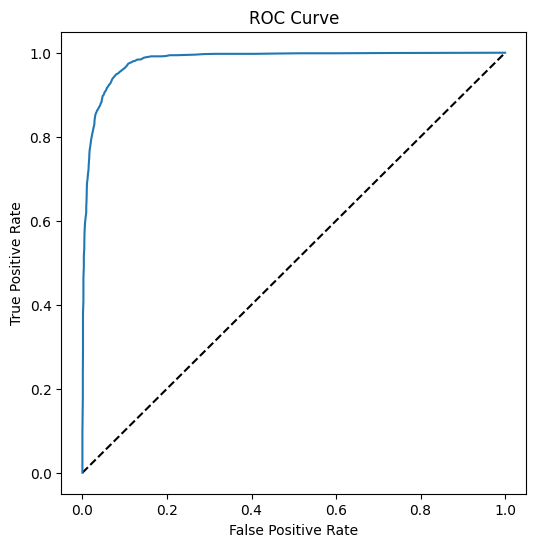

In [43]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

That looks better!

To save the trained pipeline/model for later use (e.g. `joblib.dump(model, 'model.joblib')`), then load it when needed with `joblib.load('model.joblib')` and call model.predict(X_new) or model.predict_proba(X_new) to infer labels for new data, ensuring X_new uses the same preprocessing and feature order as the training data.

- Save the trained pipeline/model for later
  - Use `joblib.dump(model, \`model.joblib\`)`.
  - Store alongside metadata (training date, data version).

- Load the saved model when needed
  - Use `joblib.load(\`model.joblib\`)` to restore the pipeline.
  - Inspect with `loaded.named_steps` to confirm preprocessing and estimator.

- Infer on new data
  - Call `model.predict(X_new)` for labels or `model.predict_proba(X_new)` for probabilities.
  - If the pipeline includes preprocessing, pass raw inputs; otherwise apply the same preprocessing before predicting.

- Ensure consistency
  - `X_new` must have the same feature order, types, and expected columns as the training data.
  - Prefer using the saved pipeline so encoders/scalers match the training transforms.

In [44]:
import joblib

# Save the model as a pickle file
filename = './diabetes_model.pkl'
joblib.dump(model, filename)

['./diabetes_model.pkl']

Next step: load the trained pipeline/model and use it to predict labels for new observations.

- Load the saved model
  - Run `import joblib`
  - Restore the pipeline using `joblib.load` with file `model.joblib`

- Prepare new data
  - Ensure `X_new` has the same feature columns, order, types, and missing-value handling as the training data
  - If the pipeline contains preprocessing, pass raw inputs; otherwise apply the same preprocessing transforms

- Predict
  - Compute labels: `preds = model.predict(X_new)`
  - Compute probabilities: `probs = model.predict_proba(X_new)[:, 1]`
  - Optionally apply a custom threshold to `probs` to derive final labels

- Validate and monitor
  - Spot-check predictions against any available ground truth
  - Track input distribution and prediction drift over time

- Save and document results
  - Export predictions with identifiers to file `predictions.csv`
  - Record model version, training date, and data version alongside results

In [45]:
# Load the model from the file
model = joblib.load(filename)

# predict on a new sample
# The model accepts an array of feature arrays (so you can predict the classes of multiple patients in a single call)
# We'll create an array with a single array of features, representing one patient
X_new = np.array([[2,180,74,24,21,23.9091702,1.488172308,22]])
print ('New sample: {}'.format(list(X_new[0])))

# Get a prediction
pred = model.predict(X_new)

# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one patient, so our prediction is the first one in the resulting array.
print('Predicted class is {}'.format(pred[0]))

New sample: [np.float64(2.0), np.float64(180.0), np.float64(74.0), np.float64(24.0), np.float64(21.0), np.float64(23.9091702), np.float64(1.488172308), np.float64(22.0)]
Predicted class is 1


## Summary

In this notebook, we looked at a range of metrics for binary classification and tried a few algorithms beyond logistic regression. We'll move onto more complex classification problems in the next notebook.